In [1]:
import xarray as xr
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Linear response model for cmip6-coarsegraining

In [6]:
def read_data(exp='unparameterized', base_path='/scratch/pp2681/calibration/OM4-AIF/basins'):
    return xr.open_dataset(os.path.join(base_path, f'{exp}.nc')).sel(code=slice(1,5)).isel(depth=0)

def ave(data, volume, dims):
    numerator = (data * volume).sum(dims)
    denominator = volume.sum(dims)
    
    nans = np.isnan(data).sum(dims)
    numerator = numerator.where(nans==0)

    return numerator / denominator

def ave3d(data, volume):
    return ave(data, volume, dims=['code','depth'])

def ave2d(data, volume):
    return ave(data, volume, dims=['code'])

def ave1d(data, volume):
    return ave(data, volume, dims=['depth'])

In [7]:
np.vstack([read_data().thetao, read_data().thetao]).shape

(120, 5)

# Fitting linear model to ANN-Control data
Response vector:
$$
r(t) = T_{parameterized}(t) - T_{control}(t)
$$
Linear response model:
$$
r(t+1)= M r(t) + b
$$
We have 60 time snapshots and 59  difference of snapshots. So,
$$
y_n = M x_n + b, \text{ for } n=1,...,59,
$$
$x_n, y_n, b \in \mathbb{R}^{5}$, $M \in \mathbb{R}^{5\times 5}$. So we have 59 samples for training and $5^2 + 5=30$ parameters to estimate. We stack unknown variables into a single matrix equation:
$$
Y = A X,
$$
where
$$
Y = [y_1,...,y_{59}] \in \mathbb{R}^{5 \times 59},
$$
$$
A = [M, b] \in \mathbb{R}^{5\times6},
$$
and
$$
X = \begin{bmatrix}
x_1 & x_2 & \cdots & x_{59} \\
1 & 1 & \cdots & 1
\end{bmatrix} \in \mathbb{R}^{6 \times 59}
$$
Solving least squares by matrix identities:
$$
Y X^T = A X X^T
$$
then
$$
Y X^T (X X^T)^{-1} = A
$$

In [8]:
r_vec = (read_data('ANN')-read_data('unparameterized')).thetao.values

In [9]:
r_vec.shape

(60, 5)

In [10]:
Y = r_vec[1:].T
X0 = r_vec[:-1].T
X = np.vstack([X0, np.ones((1,59))])

In [11]:
A = Y@X.T@np.linalg.inv(X@X.T)
M = A[:,:-1]
b  = A[:,-1]

Text(0, 0.5, 'Imag')

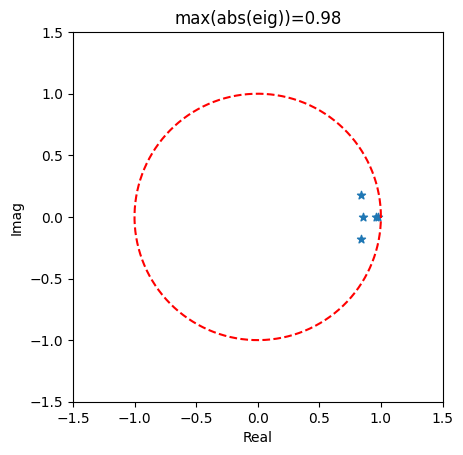

In [12]:
eigs = np.linalg.eig(M).eigenvalues
plt.scatter(eigs.real, eigs.imag, marker='*')
theta = np.linspace(0, 2*np.pi, 400)
plt.plot(np.cos(theta), np.sin(theta), 'r--')  # Unit circle

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.gca().set_aspect(1)
plt.title('max(abs(eig))=%.2f' % np.max(np.abs(eigs)))
plt.xlabel('Real')
plt.ylabel('Imag')

In [13]:
# Our linear operator describes half of the time evolution of the dynamical system
np.linalg.norm(Y-A@X) / np.linalg.norm(Y)

0.01694714887860883

# Apply linear operator for the data used for training

In [14]:
def LRM_predict_extended(r, M, b, t0=0, n_predict=240):
    '''
    Predicts `n_predict` future time steps using a linear response model.
    
    Parameters:
    - r: xarray.DataArray of shape (time, code, depth)
    - M: linear operator of shape (code*depth, code*depth)
    - t0: time index used as initial condition
    - n_predict: number of steps to predict beyond the current time series
    
    Returns:
    - r_extended: xarray.DataArray with predicted values appended
    '''
    import numpy as np
    import xarray as xr

    code = r.code.size
    original_time = r.time.values
    dt = original_time[1] - original_time[0]  # assume regular spacing

    # Create extended time coordinate
    future_times = [original_time[-1] + (i + 1) * dt for i in range(n_predict)]
    all_times = np.concatenate([original_time, future_times])

    # Expand r to accommodate future times
    r_extended = r.reindex(time=all_times).copy(deep=True)

    # Set future values to NaN explicitly (optional, for clarity)
    r_extended[t0+1:] = np.nan

    # Run recurrence
    for t in range(t0, len(all_times) - 1):
        r_extended[t+1] = M @ r_extended[t].values + b

    return r_extended

In [15]:
ann = read_data('ANN')
control = read_data('unparameterized')
zb20 = read_data('ZB20')
chang23 = read_data('MEKE-Chang')
volume = ann.volume

In [16]:
r = (ann-control).thetao

In [17]:
r_predict = LRM_predict_extended(r, M, b)

In [18]:
basin = {1: 'Southern', 2: 'Atlantic', 3: 'Pacific', 4: 'Arctic', 5: 'Indian'}

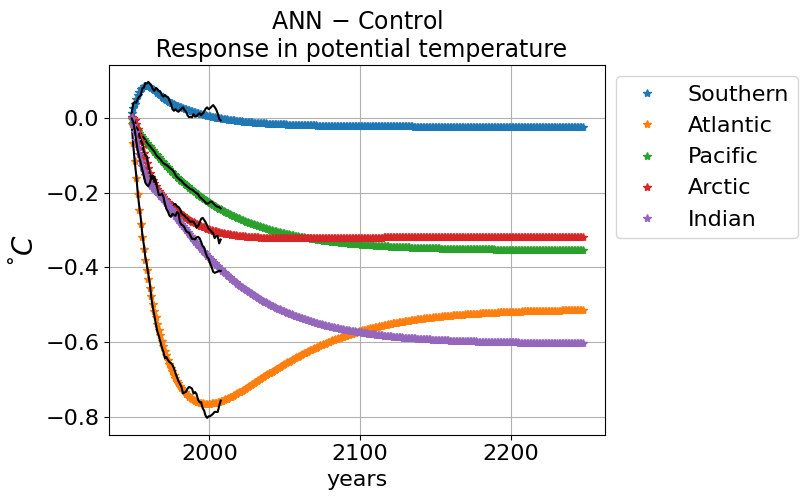

In [19]:
plt.rcParams['font.size'] = 16
for code in range(1,6):
    r_predict.sel(code=code).plot(marker='*', label=basin[code], ls='')
    r.sel(code=code).plot(color='k')
plt.title('ANN $-$ Control\n Response in potential temperature', fontsize=17)
plt.ylabel('$^{\degree}C$', fontsize=20)
plt.xlabel('years')
plt.grid()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('figures/linear-model-5d.pdf', bbox_inches='tight')

In [32]:
M

array([[ 0.88609817, -0.02590548, -0.04130418,  0.1526013 , -0.00811436],
       [-0.05024372,  0.97267569,  0.1602242 , -0.08526895, -0.10450316],
       [ 0.01859971, -0.00669156,  0.97847406,  0.0249634 , -0.01102037],
       [-0.10881189,  0.05203688,  0.05741863,  0.76350291,  0.05283314],
       [-0.04312011,  0.03677915,  0.32468406, -0.20395065,  0.86346991]])

In [33]:
b

array([[ 0.013],
       [-0.049],
       [-0.009],
       [ 0.001],
       [-0.014]])

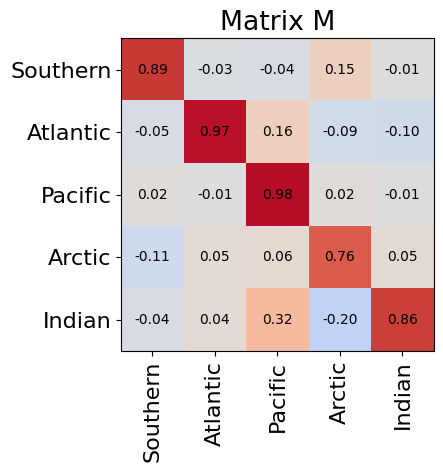

In [62]:
import cmocean
import numpy as np
import matplotlib.pyplot as plt

# Your matrix
A = np.array([
    [ 0.89, -0.03, -0.04,  0.15, -0.01],
    [-0.05,  0.97,  0.16, -0.09, -0.10],
    [ 0.02, -0.01,  0.98,  0.02, -0.01],
    [-0.11,  0.05,  0.06,  0.76,  0.05],
    [-0.04,  0.04,  0.32, -0.20,  0.86]
])

fig, ax = plt.subplots(figsize=(6, 5))

# Show heatmap
im = ax.imshow(A, cmap='coolwarm', vmin=-1.0, vmax=1.0)

# Add text annotations
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        text = ax.text(j, i, f"{A[i, j]:.2f}",
                       ha="center", va="center", color="black", fontsize=10)

# Set labels and ticks
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(['Southern', 'Atlantic', 'Pacific', 'Arctic', 'Indian'], rotation=90)
ax.set_yticklabels(['Southern', 'Atlantic', 'Pacific', 'Arctic', 'Indian'])
#ax.set_xlabel("Input dimension")
#ax.set_ylabel("Output dimension")
ax.set_title("Matrix M")

plt.tight_layout()
plt.savefig('figures/matrix.pdf')

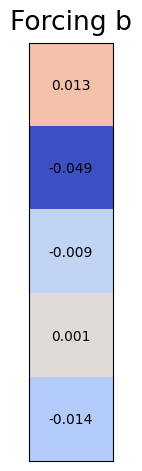

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Bias vector (reshape to column for heatmap)
b = np.array([0.013, -0.049, -0.009, 0.001, -0.014]).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(3, 5))  # Tall and narrow figure

# Show heatmap
im = ax.imshow(b, cmap='coolwarm', vmin=-0.05, vmax=0.05)

# Annotate each cell
for i in range(b.shape[0]):
    ax.text(0, i, f"{b[i, 0]:.3f}", ha='center', va='center', color='black', fontsize=10)

# Clean up ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Forcing b", pad=10)

# Add colorbar
#cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.04)
#cbar.set_label("Value")

plt.tight_layout()
plt.savefig('figures/bias.pdf')